## Binary Classification on MNIST: Training, Evaluation, and Performance Metrics

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target']

print(X.shape, y.shape)

(70000, 784) (70000,)


**Observation:**

The MNIST dataset contains 70,000 images, each of size 28×28 pixels, flattened into a 784-dimensional feature vector.

__`X.shape = (70000, 784)`__ confirms there are 70,000 instances and 784 features per instance.  each image is 28×28 pixels

__`y.shape = (70000,)`__ shows there are 70,000 corresponding labels, one for each image.


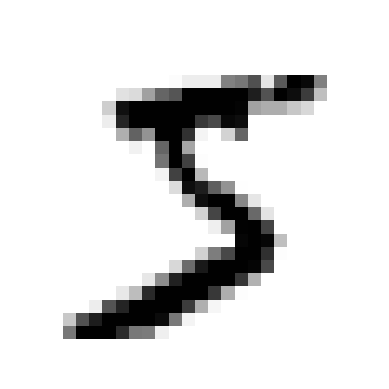

In [3]:
some_digit = X[0]          # first MNIST digit (784 pixels)
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

**Observation:**

- The first image from the MNIST dataset is visualized.
- The image is 28×28 pixels, reconstructed from the 784-dimensional feature vector.
- We can see that the number of the image looks like 5 lets see what's its corresponding value

In [4]:
y[0]

'5'

**Observation**

- It was actually 5, so we need to make the similar kind of prediction but on the unseen data


In [5]:
print(y.dtype)
y = y.astype(np.int8)
print(y.dtype)

object
int8


**Observation**

- At first the y column was object type, which is a string type. After conversion to int 8, it is now an integer type.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Observation**

- The training and test sets contain 60,000 and 10,000 digits, respectively.
- The split is made before inspecting the data closely

__`Detecting Digit ‘5’ in MNIST`__

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

**Observation**

- y_train_5 is a boolean array with 60000 entries.
- So, we want the prediction for only digit 5

In [8]:
y_train_5

array([ True, False, False, ...,  True, False, False])

In [9]:

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=42)

**Observation**

- SGDClassifier is a Stochastic Gradient Descent classifier, a linear model that can efficiently handle large datasets like MNIST.
- We are training a binary classifier to detect the digit ‘5’:
- y_train_5 = True for digit 5
- y_train_5 = False for all other digits
- __`fit() method`__

Trains the model by finding the optimal weights that separate the positive class (5) from the negative class (not-5).

In [10]:
sgd_clf.predict([some_digit])

array([ True])

**Observatoin**

- The classifier is pretty good at predicting 5s as it returned __`True`__ for __`some_digit`__ which was 5

In [11]:

skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_5):
 clone_clf = clone(sgd_clf)
 X_train_folds = X_train[train_index]
 y_train_folds = y_train_5[train_index]
 X_test_fold = X_train[test_index]
 y_test_fold = y_train_5[test_index]
 clone_clf.fit(X_train_folds, y_train_folds)
 y_pred = clone_clf.predict(X_test_fold)
 n_correct = sum(y_pred == y_test_fold)
 print(n_correct / len(y_pred)) #

0.95035
0.96035
0.9604


Cross-Validation

- We want to evaluate how well the classifier performs on unseen data.
- StratifiedKFold splits the training set into 3 folds, keeping the class proportions the same in each fold (important because 5s are rare).
- clone() Creates a fresh copy of the SGDClassifier for each fold, Ensures no information leaks between folds (no contamination).

Observation:

- It computes accuracy for each fold of the training data.
- The SGD classifier can correctly identify ~96% of digits as 5 or not-5 on unseen folds of the training data.
- High accuracy, but remember: for imbalanced data (few 5s), precision and recall are more informative than accuracy.


In [12]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Why it can be misleading

- The problem is binary classification on an imbalanced dataset:
- Only ~10% of images are digit 5 → the positive class is rare.
- 90% are not 5 → the negative class is dominant.
- A classifier could just predict “not 5” for everything:
- It would be right 90% of the time → accuracy = 90%
- But it fails completely at detecting 5s, which is the actual goal.
- Therefore, the high accuracy does not reflect the classifier’s real ability to detect digit 5.

### Confusion Matrix

In [13]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)

<img src="confusion_matrix.jpg" alt="Drawing" style="width: 600px;"/>

<img src="confusion_matrix.png" alt="Drawing" style="width: 500px;"/>

In [14]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

If We can reach the perfection then the confusion_matrix will look like this 

<img src="confusion_matrix_perfect.png" alt="Drawing" style="width: 500px;"/>

In [15]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


**Observation / Explanation**

Precision (~83.7%)
- When the classifier predicts a digit as 5, it is correct 83.7% of the time.
- This means the classifier is reasonably good at avoiding false positives (misclassifying non-5 digits as 5).

Recall (~65.1%)

- The classifier correctly detects 65.1% of all actual 5 digits.
- This means it misses about 34.9% of actual 5s (false negatives).

Insight

- Although the classifier is precise, it fails to detect some 5s, showing that accuracy alone is misleading for imbalanced datasets.
- There is a tradeoff between precision and recall: improving one often reduces the other.

## F1 Score
The **F1-score** is the harmonic mean of **precision** and **recall**:

$$
F1 = 2 \times \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}
$$

- It balances precision and recall into a **single metric**.
- Useful when you want a **single number to evaluate performance**, especially on **imbalanced datasets**.



In [16]:
f1_score(y_train_5, y_train_pred)

0.7325171197343847

The F1-score of the SGD classifier for detecting digit 5 is approximately **0.733**.

- This value represents the **harmonic mean of precision and recall**.
- It balances **precision (~83.7%)** and **recall (~65.1%)** into a single metric.
- Since the dataset is imbalanced (few 5s compared to non-5s), the F1-score provides a **more realistic measure of performance** than accuracy alone.


How SGDClassifier decides

For each instance, the classifier computes a decision score using decision_function().

- By default, a threshold of 0 is used:
   - If score > 0 → classify as positive (digit 5)
   - If score ≤ 0 → classify as negative (not 5)

In [17]:
y_scores = sgd_clf.decision_function([some_digit]) # decision_function returns the raw scores
y_scores 

array([2164.22030239])

The output y_scores is a single number representing how confident the classifier is that this image belongs to the positive class (digit 5 in your binary classifier)
                                                                                                                                   

In [18]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")

In [19]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


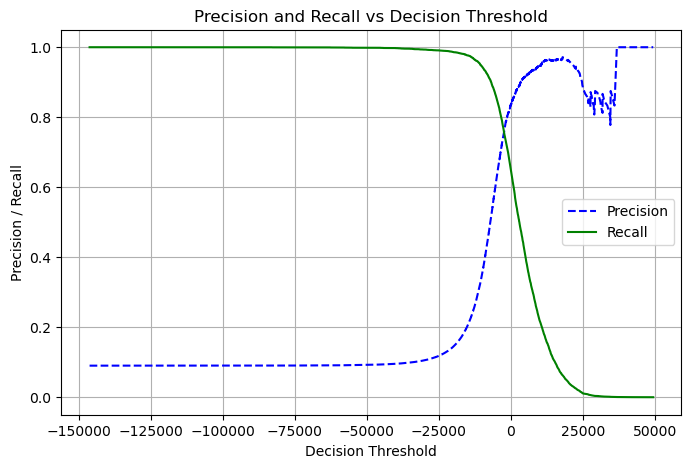

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, threshold_highlight=None):
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    
    if threshold_highlight is not None:
        plt.axvline(x=threshold_highlight, color='r', linestyle=':', label=f"Threshold = {threshold_highlight}")
    
    plt.title("Precision and Recall vs Decision Threshold")
    plt.xlabel("Decision Threshold")
    plt.ylabel("Precision / Recall")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [21]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))  # ~0.90
print(recall_score(y_train_5, y_train_pred_90))    # ~0.44

0.9000345901072293
0.4799852425751706


Interpretation

- You achieved high precision, so most of your predicted 5s are correct.
- Recall dropped significantly because the threshold is high → many actual 5s are missed.
- This demonstrates the precision/recall tradeoff:
-Increasing precision often reduces recall, and vice versa.
- Useful when false positives are costly, but less useful if you need to detect as many 5s as possible.

## ROC Curve

- It is a tool to evaluate binary classifiers over all possible thresholds.
- Unlike a single threshold evaluation (like precision/recall), the ROC curve shows the classifier’s performance across every threshold.
Compare classifiers:
- The closer the curve is to the top-left corner, the better the classifier.
- The area under the curve (AUC) quantifies performance:
    - AUC = 1 → perfect classifier
    - AUC = 0.5 → random guessing

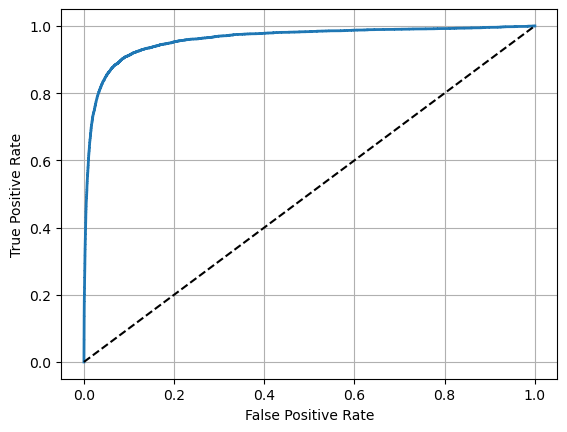

In [22]:

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')  # random classifier line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)

plot_roc_curve(fpr, tpr)
plt.show()


In [23]:
roc_auc_score(y_train_5, y_scores)  # e.g., 0.961 → very good

0.9604938554008616

**Interpretation**

- The classifier can correctly rank a random positive (5) higher than a random negative (not-5) about 96% of the time.
- High AUC confirms the classifier is effective even across all thresholds, not just the default one.

## Using Random Forest classifier

- For SGDClassifier, we used decision_function() → gives a score.
- For RandomForestClassifier, we use predict_proba() → gives probabilities for each class.
- y_scores_forest is what we feed into ROC or precision/recall calculations.

In [24]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf, X_train, y_train_5, cv=3, method="predict_proba"
)
y_scores_forest = y_probas_forest[:, 1]  # probability of positive class


### AUC curve

In [25]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

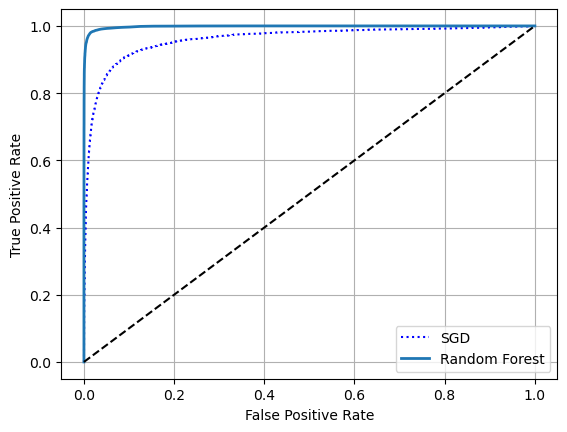

In [26]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()


In [27]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

**Interpretation**
0.998 → almost perfect. Your Random Forest is extremely good at distinguishing 5s from non-5s.

In [28]:
y_train_pred_forest = (y_scores_forest >= 0.5)

# Compute precision and recall
precision_forest = precision_score(y_train_5, y_train_pred_forest)
recall_forest = recall_score(y_train_5, y_train_pred_forest)

print("Random Forest Precision:", precision_forest)
print("Random Forest Recall:", recall_forest)

Random Forest Precision: 0.9897468089558485
Random Forest Recall: 0.8725327430363402


Interpretation

- Compared to SGD (precision ~83.7%, recall ~65.1%):
- Random Forest is much better at both detecting 5s and avoiding mistakes.
- High precision + high recall → F1-score will also be very high.

In [29]:
f1_forest = f1_score(y_train_5, y_train_pred_forest)
print("Random Forest F1-score:", f1_forest)

Random Forest F1-score: 0.9274509803921569


**Comparison with SGD Classifier**

- SGD ROC AUC: ~0.96 → very good
- Random Forest ROC AUC: ~0.998 → significantly better
- This shows that Random Forest separates the classes more effectively than SGD in this task.



***
***

# MultiClass Classification


In [30]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=int8)

- SGDClassifier, are inherently binary classifiers
- When you give such a classifier multiclass data, Scikit-Learn automatically applies the One-vs-All (OvA) strategy trains 1 binary classifier per class and each predicts whether an instance belongs to its class or not.
- It calculates scores for all 10 classifiers and selects the class with the highest score.


In [31]:
some_digit_scores = sgd_clf.decision_function([some_digit])

In [32]:
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [33]:
np.argmax(some_digit_scores)

3

- Here the actual value was5 but we got 3

In [34]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])  # predicts 5
len(ovo_clf.estimators_)      # 45 classifiers


45

One-vs-One (OvO): Train a binary classifier for every pair of classes.
    
- For 10 classes (digits 0–9), this means 45 classifiers.
- Use OneVsOneClassifier in Scikit-Learn.

In [35]:
print(ovo_clf.predict([some_digit]))

[5]


- This one gives the correct answer 

The difference between sgd_clf and ovo_clf

- sgd_clf (trained on raw pixel values) predicts 3 because linear classifiers are sensitive to feature scaling, as we discussed. If you didn’t scale the pixel values, the raw features may have led it to pick the wrong class.
- ovo_clf (One-vs-One using SGD internally) predicts 5 because of how OvO works:
- OvO trains a binary classifier for every pair of classes.
- Each classifier only sees two classes at a time, and the decision boundaries are simpler and less affected by feature scaling issues across all 10 classes.
- This can make OvO more robust for some unscaled datasets.

## Random Forest for Multiclass

In [38]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])        # predicts 5
forest_clf.predict_proba([some_digit])  # probability for each class


array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [39]:
print(forest_clf.predict([some_digit])  )

[5]


In [41]:
import pandas as pd
probas = forest_clf.predict_proba([some_digit])[0]  # 0th element to flatten

# Create a DataFrame to show digit vs probability
df = pd.DataFrame({
    "Digit": np.arange(10),
    "Probability": probas
})
print(df)

   Digit  Probability
0      0         0.00
1      1         0.00
2      2         0.01
3      3         0.08
4      4         0.00
5      5         0.90
6      6         0.00
7      7         0.00
8      8         0.00
9      9         0.01


**Observation**

- The model is very confident that the digit is a 5. (probability of 0.9 that means 90%)

***

**Evaluating Classifiers**

Use cross-validation to evaluate accuracy:

In [42]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


array([0.87365, 0.85835, 0.8689 ])

- Average accuracy is 86.9% it is because the data is not scaled, we need to scale it to improve the performance.

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

**Observation**

- The accuracy is slightly higher when the data is scaled.


***



### Error Analysis

- Understand the model’s weaknesses.
- Decide which digits need more data or preprocessing.
- Improve the model systematically.

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

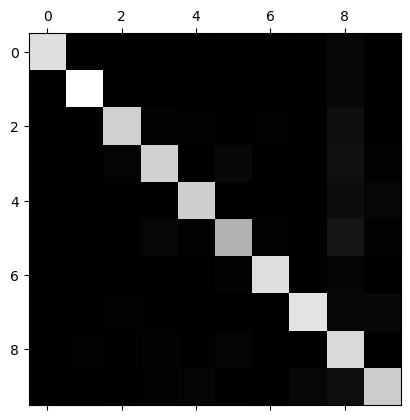

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

**Normalization of the data:**

- Actual count doesnot matter as the number of 3 can be more than 5 so it is done so that the porportions are measured and not the number of digits.
- The confusion matrix above shows the actual count so lets use the other confusion matrix in order to remove the baisness of count


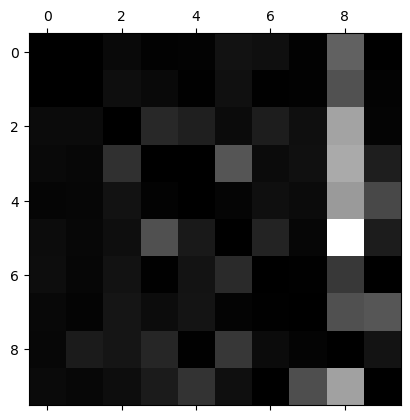

In [46]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

**Observation**

- Column for class 8 is bright → many digits are misclassified as 8.
- Row for class 8 is not bright → actual 8s are mostly classified correctly.
- You can see which classes the model struggles with.Example: 3s and 5s are often confused.

- This converts the numbers into error rates, making it easier to compare errors across different digits
- We fill the diagonal with zeros so we can see only the errors, since the diagonal represents correct predictions.

__`Improvement can be done by:`__

- **Gathering more training data** for confusing digits.
- **Engineering better features** (e.g., counting closed loops: 8 has 2, 6 has 1, 5 has 0).
- **Image preprocessing** (centering, enhancing patterns) to make distinguishing features more prominent.

In [57]:
def plot_and_save_digits(instances, images_per_row=5, filename="digits.png"):
    """
    Plot a grid of digit images and save to a PNG file.
    
    Parameters:
    - instances: array-like, shape (n_samples, 784)
        Flattened digit images to plot.
    - images_per_row: int
        Number of images per row.
    - filename: str
        Name of the PNG file to save.
    """
    n_images = len(instances)
    n_rows = (n_images - 1) // images_per_row + 1
    plt.figure(figsize=(images_per_row, n_rows))
    
    for i, image in enumerate(instances):
        plt.subplot(n_rows, images_per_row, i + 1)
        plt.imshow(image.reshape(28, 28), cmap=plt.cm.binary, interpolation='nearest')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"Saved {filename} with {n_images} images.")

# Define the classes
cl_a, cl_b = 3, 5

# Split the images by true/predicted class
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# Save each group as a separate PNG
plot_and_save_digits(X_aa[:25], images_per_row=5, filename="3_correct.png")
plot_and_save_digits(X_ab[:25], images_per_row=5, filename="3_misclassified_as_5.png")
plot_and_save_digits(X_ba[:25], images_per_row=5, filename="5_misclassified_as_3.png")
plot_and_save_digits(X_bb[:25], images_per_row=5, filename="5_correct.png")

Saved 3_correct.png with 25 images.
Saved 3_misclassified_as_5.png with 25 images.
Saved 5_misclassified_as_3.png with 25 images.
Saved 5_correct.png with 25 images.


### 3 vs 5 Classification Errors

The plot below shows the error analysis for digits 3 and 5:

![3 and 5 classification errors](3_correct.png) ![3 and 5 classification errors](3_misclassified_as_5.png)


![3 and 5 classification errors](5_correct.png) ![3 and 5 classification errors](5_misclassified_as_3.png)

***
***

In [58]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Create two labels for each digit
y_train_large = (y_train >= 7)       # True if digit is large (7, 8, 9)
y_train_odd   = (y_train % 2 == 1)   # True if digit is odd
y_multilabel  = np.c_[y_train_large, y_train_odd]

# Train a KNeighborsClassifier with multilabel targets
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# Make a prediction
knn_clf.predict([some_digit])
# Output: array([[False, True]]) -> digit 5 is not large, but odd


array([[False,  True]])

__`y_multilabel`__ contains two labels per digit:

        - Is the digit large (≥7)?
        - Is the digit odd?
- KNeighborsClassifier supports multilabel classification, so it can predict both labels at once.

In [59]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")
# Output: 0.976


0.9764102655606048

- average="macro" → simple average of F1 scores for all labels (treats all labels equally).
- average="weighted" → weights F1 by the number of instances for each label (useful if some labels are much more common).
- Averaging per-label metrics like F1 gives a more balanced evaluation

In [60]:
class_counts = np.bincount(y_train)  # counts number of occurrences of each class
print(class_counts)

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


***
***

## Multioutput Classification

- In multilabel classification, each instance can have multiple binary labels (e.g., [1, 0, 1] for Alice, Bob, Charlie).
- In multioutput classification, each label can take more than two possible values.
- Essentially, the model predicts multiple outputs, and each output can be multiclass.

In [61]:
# Adding random noise to training and test images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

# Targets are the original images
y_train_mod = X_train
y_test_mod = X_test


In [64]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

# Predicting the clean version of a noisy image
some_index = 0  # example index
clean_digit = knn_clf.predict([X_test_mod[some_index]])




**Why we do this**

This creates a multioutput-multiclass classification problem:
    - Multioutput → we predict multiple outputs (one for each pixel, 784 outputs per image).
    - Multiclass → each output (pixel) can take multiple values (0–255).

The goal is to train a model that can denoise images.
- After training, we can feed a noisy image to the model and it will try to reconstruct the original clean image.

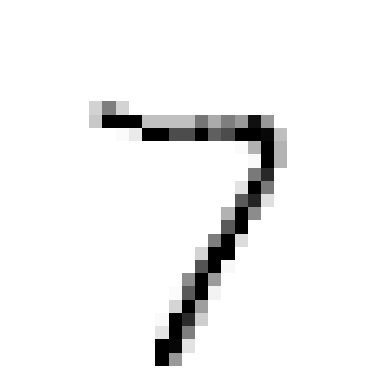

In [66]:
def plot_digit(image):
    """
    Plots a single digit image.
    image: 1D array of 784 pixels (28x28)
    """
    plt.imshow(image.reshape(28, 28), cmap=plt.cm.binary, interpolation='nearest')
    plt.axis('off')
    plt.show()

plot_digit(clean_digit[some_index])

Noisy input image:


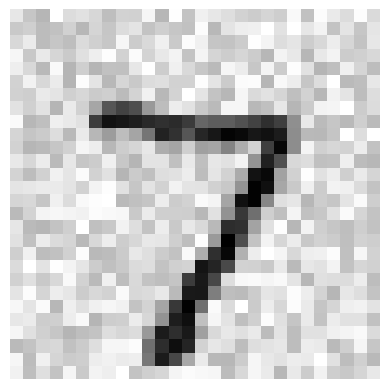

In [ ]:
print("Noisy input image:")
noisy_image = X_test_mod[some_index]
plot_digit(noisy_image)

In [69]:
clean_pred = knn_clf.predict([noisy_image])[0]

Predicted clean image:


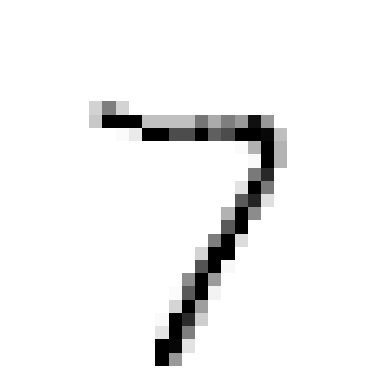

In [70]:
print("Predicted clean image:")
plot_digit(clean_pred)

Original clean image:


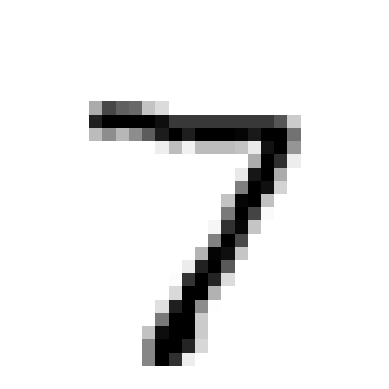

In [71]:
print("Original clean image:")
plot_digit(y_test_mod[some_index])